In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

### Basic Features
- Driver features:
    - `driver_ref`: Categorical identifier for driver
    - `driver_age`
    - `driver_nationality`
- Driver (current) standings:
    - `driver_position`
    - `driver_points`
    - `driver_wins`
    - `driver_points_lag`: Point difference with driver ahead
    - `driver_points_lead`: Point difference with driver behind
    - `days_since_last_race`
- Constructor features:
    - `constructor_ref`: Categorical identifier for constructor
    - `constructor_nationality`
- Constructor (current) standings:
    - `constructor_position`
    - `constructor_points`
    - `constructor_wins`
    - `constructor_points_lag`: Point difference with constructor ahead
    - `constructor_points_lead`: Point difference with constructor behind
- Driver contribution:
    - `position_diff`: Difference in position of driver and constructor
    - `points_ratio`: How many of the constructor's points come from this driver
    - `wins_ratio`: How many of constructor's wins come from this driver


### Past Race Features
- For each of the past 3 races:
    - `driver_position`
    - `driver_points`
    - `driver_grid`
    - `position_gain`
    - `driver_rank`
    - `pct_laps_completed`
    - `dnf`
    - `constructor_points`

### Upcoming Race Features
- For the upcoming 3 races:
    - `round`
    - `circuitId`: Categorical identifier for the circuit

In [2]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('f1/f1.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

Matplotlib is building the font cache; this may take a moment.


In [53]:
with open('f1/position/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=0))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [3]:
utils.validate_feature_tables('position', conn)

Validating train
train labels size: 7,453 x 3
train feats size: 7,453 x 53

Validating val
val labels size: 499 x 3
val feats size: 499 x 53

Validating test
test labels size: 760 x 2
test feats size: 760 x 52

✅ All tables are valid!


In [4]:
%%sql train_df <<
from position_train_feats

In [5]:
infer_df_stype(train_df)

{'driverId': <stype.numerical: 'numerical'>,
 'date': <stype.timestamp: 'timestamp'>,
 'position': <stype.numerical: 'numerical'>,
 'week_of_year': <stype.categorical: 'categorical'>,
 'driver_ref': <stype.text_embedded: 'text_embedded'>,
 'driver_age': <stype.numerical: 'numerical'>,
 'driver_nationality': <stype.text_embedded: 'text_embedded'>,
 'driver_position': <stype.numerical: 'numerical'>,
 'driver_points': <stype.numerical: 'numerical'>,
 'driver_wins': <stype.numerical: 'numerical'>,
 'driver_points_lag': <stype.numerical: 'numerical'>,
 'driver_points_lead': <stype.numerical: 'numerical'>,
 'days_since_last_race': <stype.numerical: 'numerical'>,
 'constructor_ref': <stype.text_embedded: 'text_embedded'>,
 'constructor_nationality': <stype.text_embedded: 'text_embedded'>,
 'constructor_position': <stype.numerical: 'numerical'>,
 'constructor_points': <stype.numerical: 'numerical'>,
 'constructor_wins': <stype.numerical: 'numerical'>,
 'constructor_points_lag': <stype.numerica

## Feature Importances

In [3]:
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-f1-position'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%%sql train_df <<
select * from position_train_feats;

In [5]:
%%sql val_df <<
select * from position_val_feats;

In [6]:
train_dset = Dataset(
    train_df,
    col_to_stype=task_to_stypes[TASK],
    target_col=task_params['target_col'],
).materialize()
val_tf = train_dset.convert_to_tensor_frame(val_df)

In [7]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

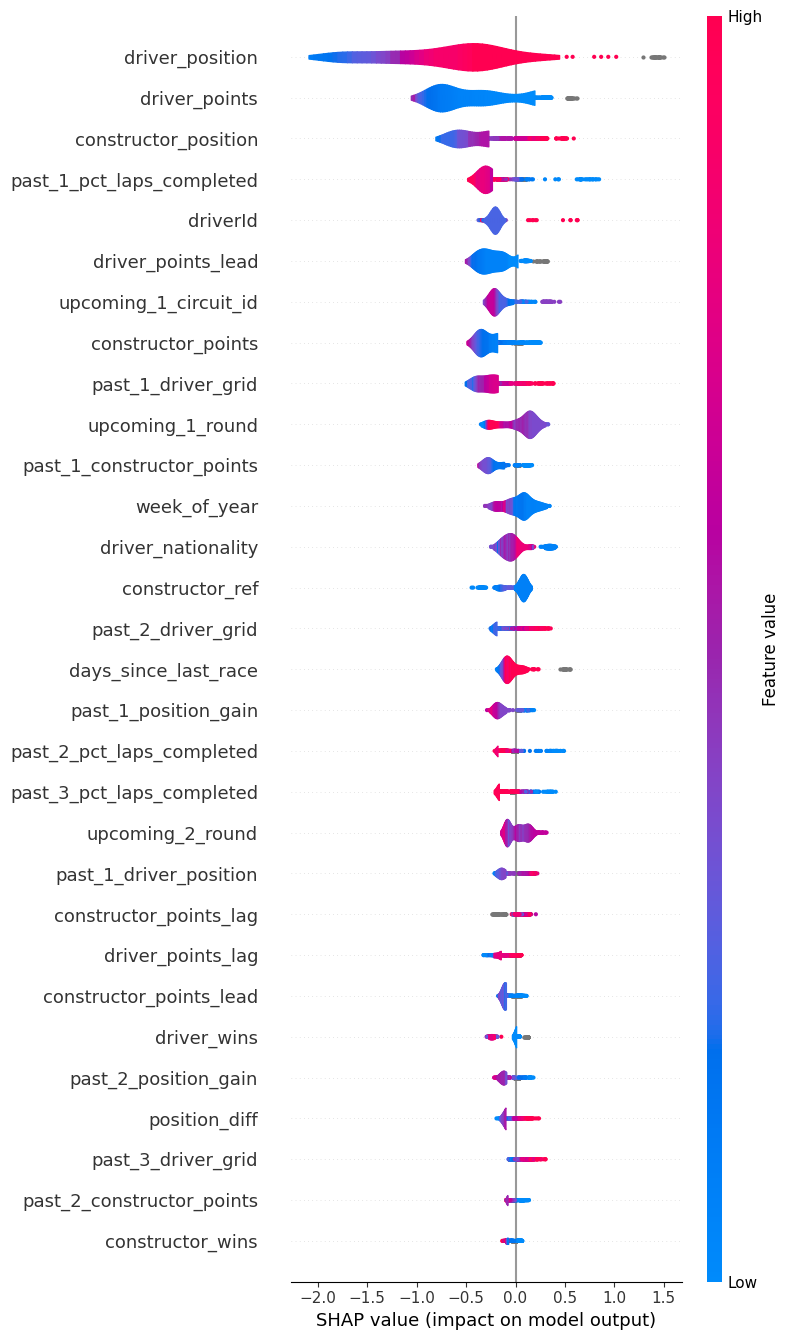

In [8]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[:10_000])
shap_values = explainer.shap_values(val_arr, pred[:10_000])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

In [17]:
conn.close()